In [1]:
import torch
import numpy as np
from tqdm import tqdm
from torchvision import transforms, datasets

from core.Util import show_plt
from model.valina_gan import Discriminator, Generator

In [2]:
device = 'cpu'
if torch.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'

In [3]:
train_dataset = datasets.MNIST(root = "../data/",
                               train = True,
                               transform = transforms.ToTensor())

In [4]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = torch.nn.BCELoss()
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
genr_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)

In [5]:
def train_step(model, x, target, criterion, optimizer):
    model.train()
    pred = model(x)
    loss = criterion(pred, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

### 주의사항
 - 모델에 시드 값이 정규분포를 따를때 생성기의 학습이 잘됨 -> 그냥 랜덤값이면 학습 안됨
 - 모델 만들때, Normalizer, Activation 함수가 어떤것이냐에 따라 차이를 많이 보임
   - 현재 코드에서는 LayerNormalizer, LeakliyRelu 가 가장 빠르게 모드 붕괴를 해소함

  0%|          | 0/4 [00:00<?, ?it/s, 1/60000, dis_loss: 0.0630, gen_loss: 3.1574]

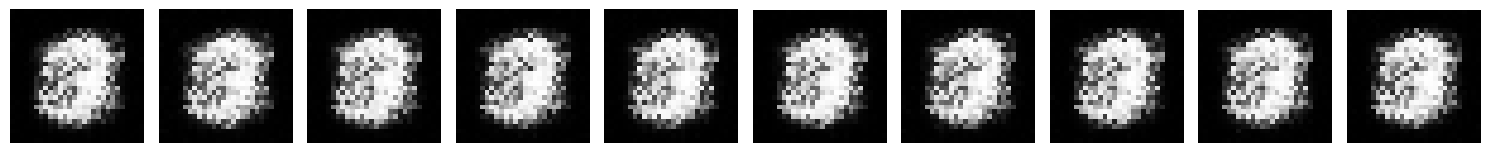

  0%|          | 0/4 [00:55<?, ?it/s, 10001/60000, dis_loss: 0.0836, gen_loss: 3.6926]

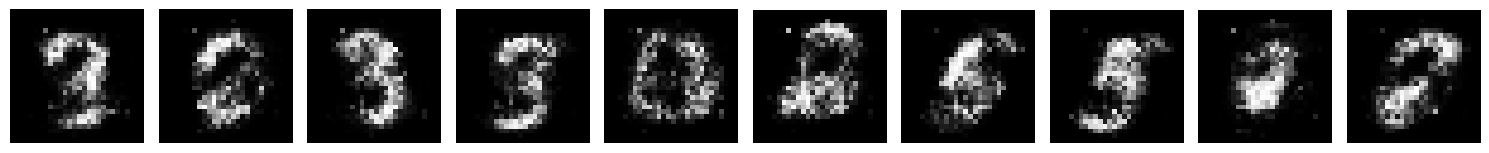

  0%|          | 0/4 [02:00<?, ?it/s, 20001/60000, dis_loss: 0.1098, gen_loss: 3.5658]

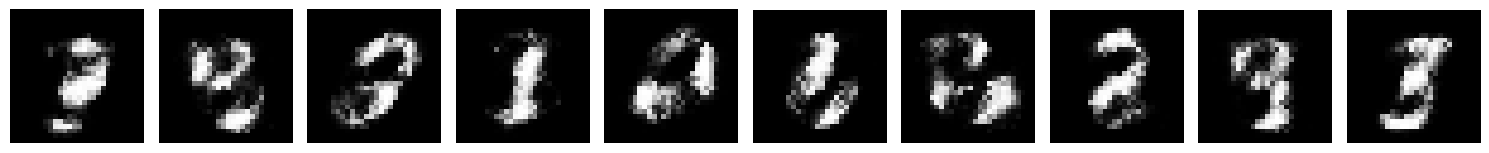

  0%|          | 0/4 [03:18<?, ?it/s, 30001/60000, dis_loss: 0.1401, gen_loss: 3.3899]

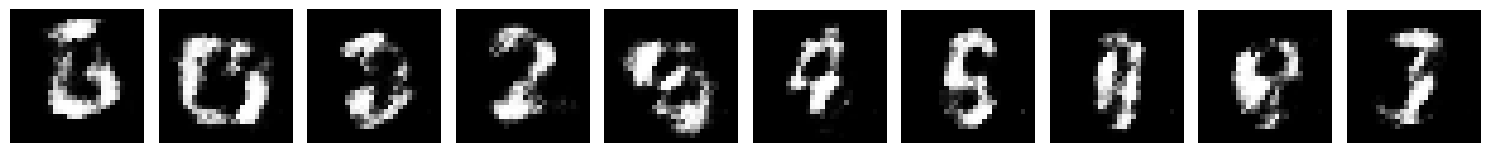

  0%|          | 0/4 [04:42<?, ?it/s, 40001/60000, dis_loss: 0.1695, gen_loss: 3.2277]

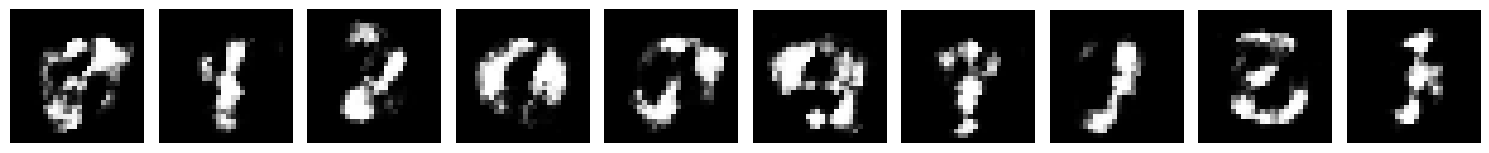

  0%|          | 0/4 [06:16<?, ?it/s, 50001/60000, dis_loss: 0.1912, gen_loss: 3.0909]

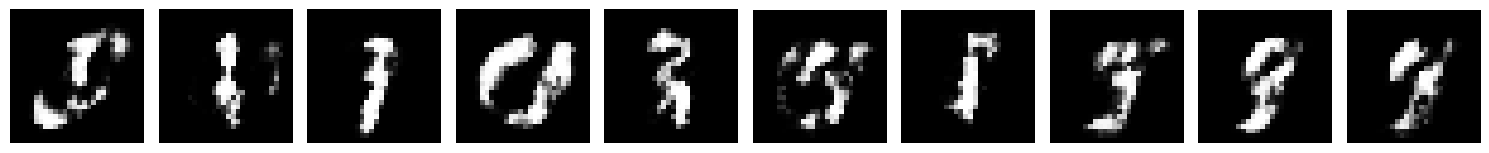

 25%|██▌       | 1/4 [08:09<24:28, 489.50s/it, 1/60000, dis_loss: 0.0972, gen_loss: 4.9025]    

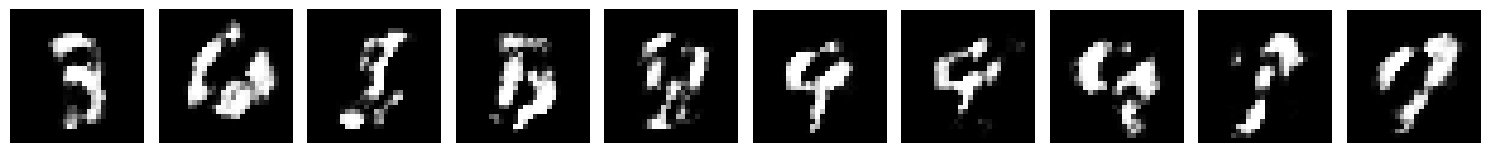

 25%|██▌       | 1/4 [09:05<24:28, 489.50s/it, 10001/60000, dis_loss: 0.2758, gen_loss: 2.5208]

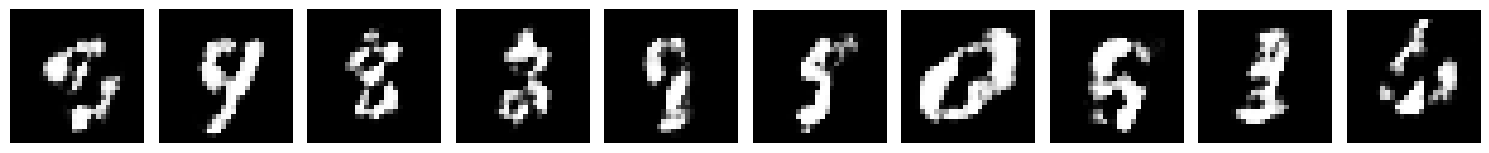

 25%|██▌       | 1/4 [10:14<24:28, 489.50s/it, 20001/60000, dis_loss: 0.2805, gen_loss: 2.4890]

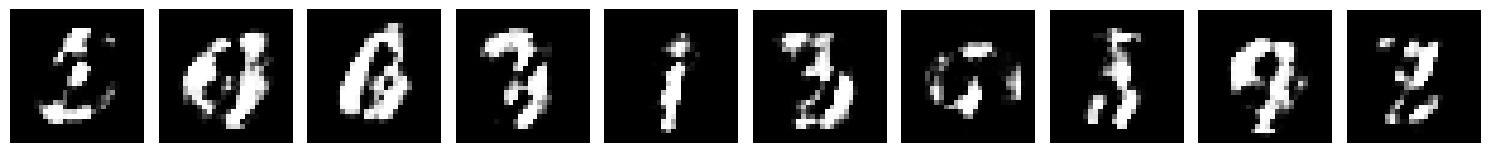

 25%|██▌       | 1/4 [11:34<34:44, 694.80s/it, 29853/60000, dis_loss: 0.2835, gen_loss: 2.4660]


KeyboardInterrupt: 

In [7]:
progress = tqdm(range(4))
for epoch in progress:
    dis_losses = []
    gen_losses = []
    
    for step, (x, target) in enumerate(train_dataset):
        x = x.reshape(-1).to(device)
        target = torch.Tensor([1.]).to(device)
        pos_loss = train_step(discriminator, x, target, criterion, disc_optimizer)

        seed = torch.randn(100).to(device)
        x = generator(seed).detach()
        target = torch.Tensor([0.]).to(device)
        neg_loss = train_step(discriminator, x, target, criterion, disc_optimizer)

        seed = torch.randn(100).to(device)
        x = generator(seed)
        target = torch.Tensor([1.]).to(device)
        gen_loss = train_step(discriminator, x, target, criterion, genr_optimizer)

        dis_losses.append(pos_loss)
        dis_losses.append(neg_loss)
        gen_losses.append(gen_loss)

        progress.set_postfix_str(f"{step + 1}/{len(train_dataset)}, dis_loss: {np.mean(dis_losses):.04f}, gen_loss: {np.mean(gen_losses):.04f}")
        if step % 10000 == 0:
            show_plt(generator, 10)

generator.eval()
show_plt(generator, 10)

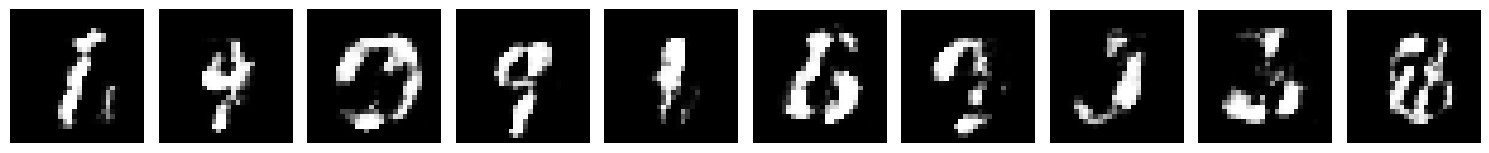

In [7]:
generator.eval()
show_plt(generator, 10)